<a href="https://colab.research.google.com/github/ciprianisamuele/ML-with-python/blob/main/bb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
L._prev

{Value(data=-7.0, label=y)}

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def sigmoid(self):
    x = self.data
    t = 1/(1+math.exp(-x))
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += t*(1-t) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def relu(self):
    out = Value(max(0, self.data), (self,), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(L)

NameError: name 'L' is not defined

In [ ]:
import random

In [ ]:
L.backward()

In [ ]:
x1.grad

0.0009102211801218266

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([-3.0]).double()                ; x2.requires_grad = True
x3 = torch.Tensor([1.0]).double()
x3.requires_grad = True
w1 = torch.Tensor([3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([-2.0]).double()                ; w2.requires_grad = True
w3 = torch.Tensor([7.0]).double()                ; w3.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

z1 = x1*w1+x1*w2+x3*w3
z2 = x2*w1+ x2*w2 + x2*w3
z3 = x3*w1+ x3*w2 + x3*w3
y = z1+z2+z3

o = torch.sigmoid(y)


print(o.data.item())
o.backward()
print('---')

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.0009110511944006454
---
---
x2 0.007281769440974613
w2 -2.168404344971009e-19
x1 0.0009102211801218266
w1 -2.168404344971009e-19


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1), label=f'w{i+1}') for i in range(nin)]
    self.b = Value(random.uniform(-1,1), label='b')

  def __call__(self, x, act):
    # w * x + b
    out = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    if act:
      out = out.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x, act):

    outs = [n(x, act) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
      for i, layer in enumerate(self.layers):
          if i < len(self.layers) - 1:
              x = layer(x, 1)
          else:
              x = layer(x, 0)
      return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
neur = Neuron(2)

x = [1,2]
y = neur(x)

y.backward()
draw_dot(y)

neur.parameters()

[Value(data=-0.7988027524423538),
 Value(data=0.5224695117632692),
 Value(data=-0.993581331363872)]

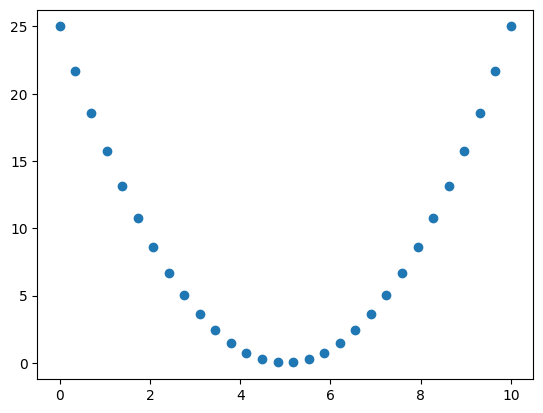

In [ ]:
def f(x):
   return (x-5)**2


xprov = np.linspace(0,10,30)
yvera = f(xprov)

plt.plot(xprov,f(xprov), 'o')

In [ ]:
xprov
x_test = [[x] for x in xprov]
yvera

array([ 0.        ,  5.53463929, 11.26513479, 16.22086322, 20.10352872])

In [ ]:
n = MLP(1, [10, 10, 10, 10, 1])
x_test = [[x] for x in xprov]



for i in range(100):



  y_pred = [n(x) for x in x_test]

  loss = sum([(yp-y)**2 for yp,y in zip(y_pred,y_test)])/len(yvera)
 # print(f'Epoch {i+1}, Loss: {loss.data}')
  for p in n.parameters():
    p.grad = 0.0

  loss.backward()


  for p in n.parameters():

    p.data += -0.001*p.grad



In [ ]:
n([7.0])

Value(data=13.602689651108731)

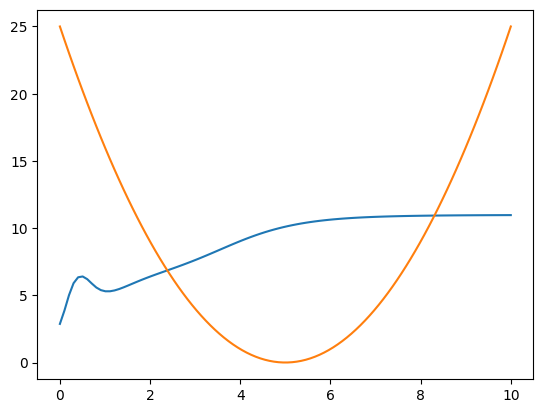

In [ ]:

xgraf = np.linspace(0,10,100)


f_mia = []
for i in [[x] for x in xgraf]:
  f_mia.append(n(i).data)

plt.plot(xgraf,f_mia)
plt.plot(xgraf,f(xgraf))



In [ ]:
n.parameters()

[Value(data=-1.007716570005387),
 Value(data=0.14574283515438888),
 Value(data=0.5656046860994596),
 Value(data=-0.02872523298961466),
 Value(data=0.8171260461188132),
 Value(data=-0.8773431320443604),
 Value(data=-1.6273463388277387),
 Value(data=-0.7123522000667749),
 Value(data=0.5642907669309255),
 Value(data=1.4835934065638976),
 Value(data=2.4343744084922934),
 Value(data=5.261807282474984),
 Value(data=7.100822147679616)]

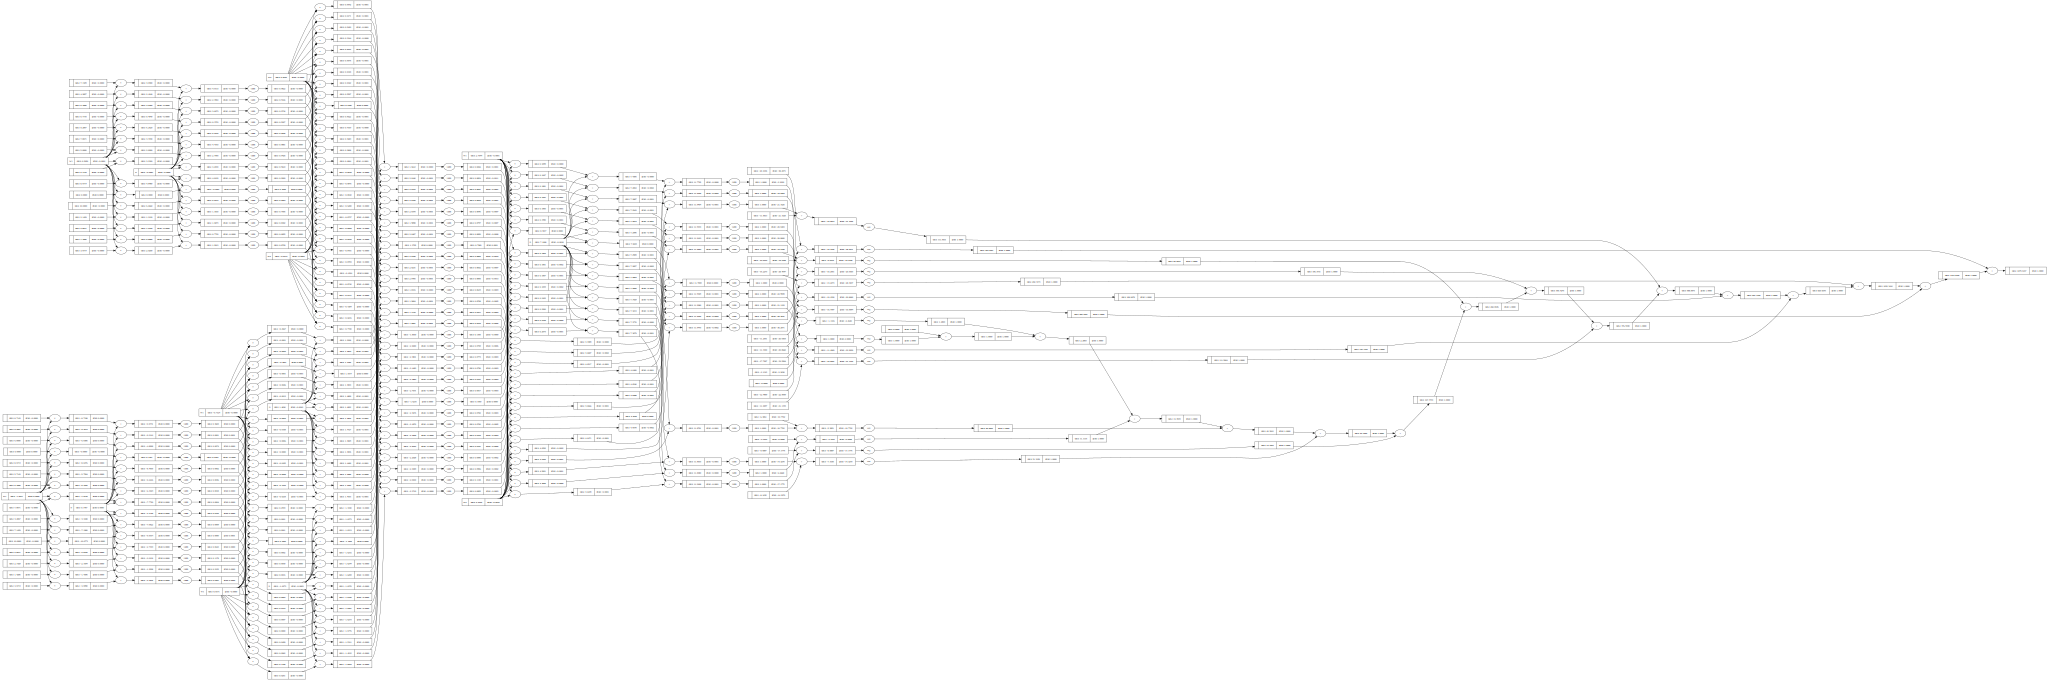

In [ ]:
draw_dot(loss)

In [ ]:
n = MLP(1, [10, 10, 10, 10, 1])  # MLP con più livelli

# Dati di test
x_test = [Value(3.0)]
y_test = Value(2.0)

# Learning rate
learning_rate = 0.1  # Tasso di apprendimento

# Allenamento
for epoch in range(1000):  # Numero di epoch
    # Forward pass
    y_pred = n(x_test)

    # Calcolo della perdita (Mean Squared Error)
    loss = (y_pred - y_test) ** 2

    # Output della perdita
    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.data}')

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Aggiornamento dei parametri
    for p in n.parameters():
        p.data -= learning_rate * p.grad

# Test del modello
y_pred = n(x_test)
print(f'Prediction for input 3.0: {y_pred.data}')

Epoch 1, Loss: 11.795393713517651
Epoch 101, Loss: 0.0
Epoch 201, Loss: 0.0
Epoch 301, Loss: 0.0
Epoch 401, Loss: 0.0
Epoch 501, Loss: 0.0
Epoch 601, Loss: 0.0
Epoch 701, Loss: 0.0
Epoch 801, Loss: 0.0
Epoch 901, Loss: 0.0
Prediction for input 3.0: 2.0
